# Decision trees (with extracted attributes)

In [25]:
import numpy as np
import pandas as pd
import pydotplus
from collections import defaultdict
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from IPython.display import Image

In [4]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [5]:
df = pd.read_csv('training_preprocessed.csv')
df = df.drop('Unnamed: 0', 1)
df.head()

,Occupancy,WorkingHours,Delta Temperature,Delta Humidity,Delta Light,Delta CO2
0,1,1,2.79,-0.828,420.0,207.580000
1,1,1,2.76,-0.855,420.0,199.830000
2,1,1,2.71,-0.900,420.0,190.830000
3,1,1,2.71,-0.900,413.0,187.330000
4,1,1,2.71,-0.900,413.0,187.996667


In [10]:
class_name = 'Occupancy'
class_labels = df['Occupancy'].values
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res

In [35]:
dt = tree.DecisionTreeClassifier()
f1_for_0 = metrics.make_scorer(metrics.f1_score, pos_label = 0)
f1_for_1 = metrics.make_scorer(metrics.f1_score, pos_label = 1)

parameters = {'criterion': ['gini', 'entropy'], 
              'max_depth': np.arange(1,11),
              'min_samples_leaf': np.arange(1,100,5),
              'min_samples_split': np.arange(2,200,5)}
clf_1 = GridSearchCV (estimator = dt, param_grid = parameters, scoring = {'f1_for_class_1': f1_for_1, 'f1_for_class_0': f1_for_0}, cv = 5, refit = 'f1_for_class_1')

In [36]:
clf_1.fit(df.drop('Occupancy', 1), class_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n...
                         'min_samples_split': array([  2,   7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,
        67,  72,  77,  82,

In [37]:
results = pd.DataFrame(clf_1.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_f1_for_class_1,...,std_test_f1_for_class_1,rank_test_f1_for_class_1,split0_test_f1_for_class_0,split1_test_f1_for_class_0,split2_test_f1_for_class_0,split3_test_f1_for_class_0,split4_test_f1_for_class_0,mean_test_f1_for_class_0,std_test_f1_for_class_0,rank_test_f1_for_class_0
0,0.006968,0.001515,0.005274,0.001320,gini,1,1,2,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.933962,...,0.023216,59,0.981273,0.999212,0.995256,0.994717,0.987203,0.991531,0.006435,61
1,0.005191,0.000045,0.003974,0.000087,gini,1,1,7,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.933962,...,0.023216,59,0.981273,0.999212,0.995256,0.994717,0.987203,0.991531,0.006435,61
2,0.005253,0.000141,0.003931,0.000056,gini,1,1,12,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.933962,...,0.023216,59,0.981273,0.999212,0.995256,0.994717,0.987203,0.991531,0.006435,61
3,0.005564,0.000550,0.004652,0.000773,gini,1,1,17,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.933962,...,0.023216,59,0.981273,0.999212,0.995256,0.994717,0.987203,0.991531,0.006435,61
4,0.005360,0.000146,0.003999,0.000078,gini,1,1,22,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.933962,...,0.023216,59,0.981273,0.999212,0.995256,0.994717,0.987203,0.991531,0.006435,61
5,0.005221,0.000072,0.003934,0.000066,gini,1,1,27,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.933962,...,0.023216,59,0.981273,0.999212,0.995256,0.994717,0.987203,0.991531,0.006435,61
6,0.005219,0.000038,0.003963,0.000066,gini,1,1,32,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.933962,...,0.023216,59,0.981273,0.999212,0.995256,0.994717,0.987203,0.991531,0.006435,61
7,0.005221,0.000065,0.003939,0.000039,gini,1,1,37,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.933962,...,0.023216,59,0.981273,0.999212,0.995256,0.994717,0.987203,0.991531,0.006435,61
8,0.005297,0.000119,0.003944,0.000046,gini,1,1,42,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.933962,...,0.023216,59,0.981273,0.999212,0.995256,0.994717,0.987203,0.991531,0.006435,61
9,0.005230,0.000044,0.003946,0.000041,gini,1,1,47,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.933962,...,0.023216,59,0.981273,0.999212,0.995256,0.994717,0.987203,0.991531,0.006435,61


In [46]:
print('Best parameters:')
results.loc[1600]

Best parameters:


mean_fit_time                                                         0.0105914
std_fit_time                                                        0.000212568
mean_score_time                                                      0.00411959
std_score_time                                                      8.16617e-05
param_criterion                                                            gini
param_max_depth                                                               3
param_min_samples_leaf                                                        1
param_min_samples_split                                                       2
params                        {'criterion': 'gini', 'max_depth': 3, 'min_sam...
split0_test_f1_for_class_1                                             0.936613
split1_test_f1_for_class_1                                             0.996973
split2_test_f1_for_class_1                                             0.982072
split3_test_f1_for_class_1              

In [39]:
dt_best = clf_1.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

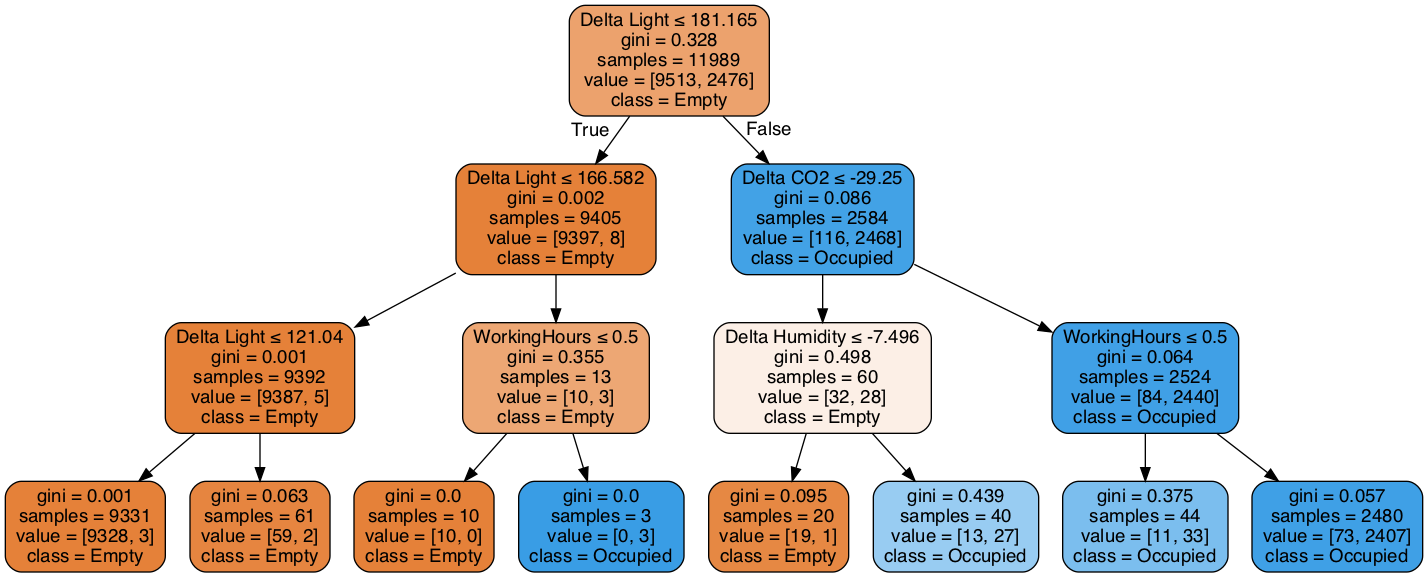

In [47]:
class_labels = df['Occupancy'].values
dt_best.fit(df.drop('Occupancy', 1), class_labels)

dot_data = tree.export_graphviz(dt_best, out_file=None,
                                feature_names=df.drop('Occupancy', 1).columns,
                                class_names=['Occupied' if x == 1 else 'Empty' for x in dt_best.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [54]:
for col, imp in zip(df.drop('Occupancy', 1).columns, dt_best.feature_importances_):
    print(col, imp)

WorkingHours 0.0023576583463508724
Delta Temperature 0.0
Delta Humidity 0.002783879659342574
Delta Light 0.9870254002395216
Delta CO2 0.007833061754784805


## Using the best dt to predict the test class

In [48]:
df_test = pd.read_csv('test_preprocessed.csv')

In [49]:
df_test = df_test.drop('Unnamed: 0', 1)
df_test.head()

,Occupancy,WorkingHours,Delta Temperature,Delta Humidity,Delta Light,Delta CO2
0,1,1,2.76,-0.832500,423.5,200.330000
1,1,1,2.76,-0.900000,420.0,194.580000
2,1,1,2.71,-0.900000,413.0,175.663333
3,1,0,1.81,-1.793333,419.0,58.000000
4,1,0,1.76,-1.810000,419.0,62.000000


In [50]:
res = prepare_dataset(df_test, class_name)
df_test, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res

In [51]:
# just verifying the effect of Guidotti's 'prepare_dataset' function
df_test.head()

,WorkingHours,Delta Temperature,Delta Humidity,Delta Light,Delta CO2,Occupancy
0,1,2.76,-0.832500,423.5,200.330000,1
1,1,2.76,-0.900000,420.0,194.580000,1
2,1,2.71,-0.900000,413.0,175.663333,1
3,0,1.81,-1.793333,419.0,58.000000,1
4,0,1.76,-1.810000,419.0,62.000000,1


In [52]:
# actual prediction:
y_pred_tr = dt_best.predict(df.drop('Occupancy',1))
y_pred_test = dt_best.predict(df_test.drop('Occupancy',1))

### Analyzing the classification performance

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [56]:
print('Train Accuracy %s' % accuracy_score(df['Occupancy'].values, y_pred_tr))
print('Train F1-score %s' % f1_score(df['Occupancy'].values, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(df_test['Occupancy'].values, y_pred_test))
print('Test F1-score %s' % f1_score(df_test['Occupancy'].values, y_pred_test, average=None))
print(classification_report(df_test['Occupancy'].values, y_pred_test))
confusion_matrix(df_test['Occupancy'].values, y_pred_test)

Train Accuracy 0.9914087913921095
Train F1-score [0.99456034 0.97957565]

Test Accuracy 0.9920419911953945
Test F1-score [0.99487403 0.98221718]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4604
           1       0.97      1.00      0.98      1302

    accuracy                           0.99      5906
   macro avg       0.98      0.99      0.99      5906
weighted avg       0.99      0.99      0.99      5906



array([[4561,   43],
       [   4, 1298]])